In [1]:
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

Global seed set to 0


In [2]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=1

In [3]:
sc.set_figure_params(figsize=(8, 8))

In [ ]:
adata = sc.read_h5ad('/lorien/hlhs/rdata/human_v2/integrated/PART07.merged.clean_cbn.ann.h5ad')

In [6]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample"
)

In [8]:
# run PCA then generate UMAP plots
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [9]:
adata.obsm['X_pcaumap']=adata.obsm['X_umap']

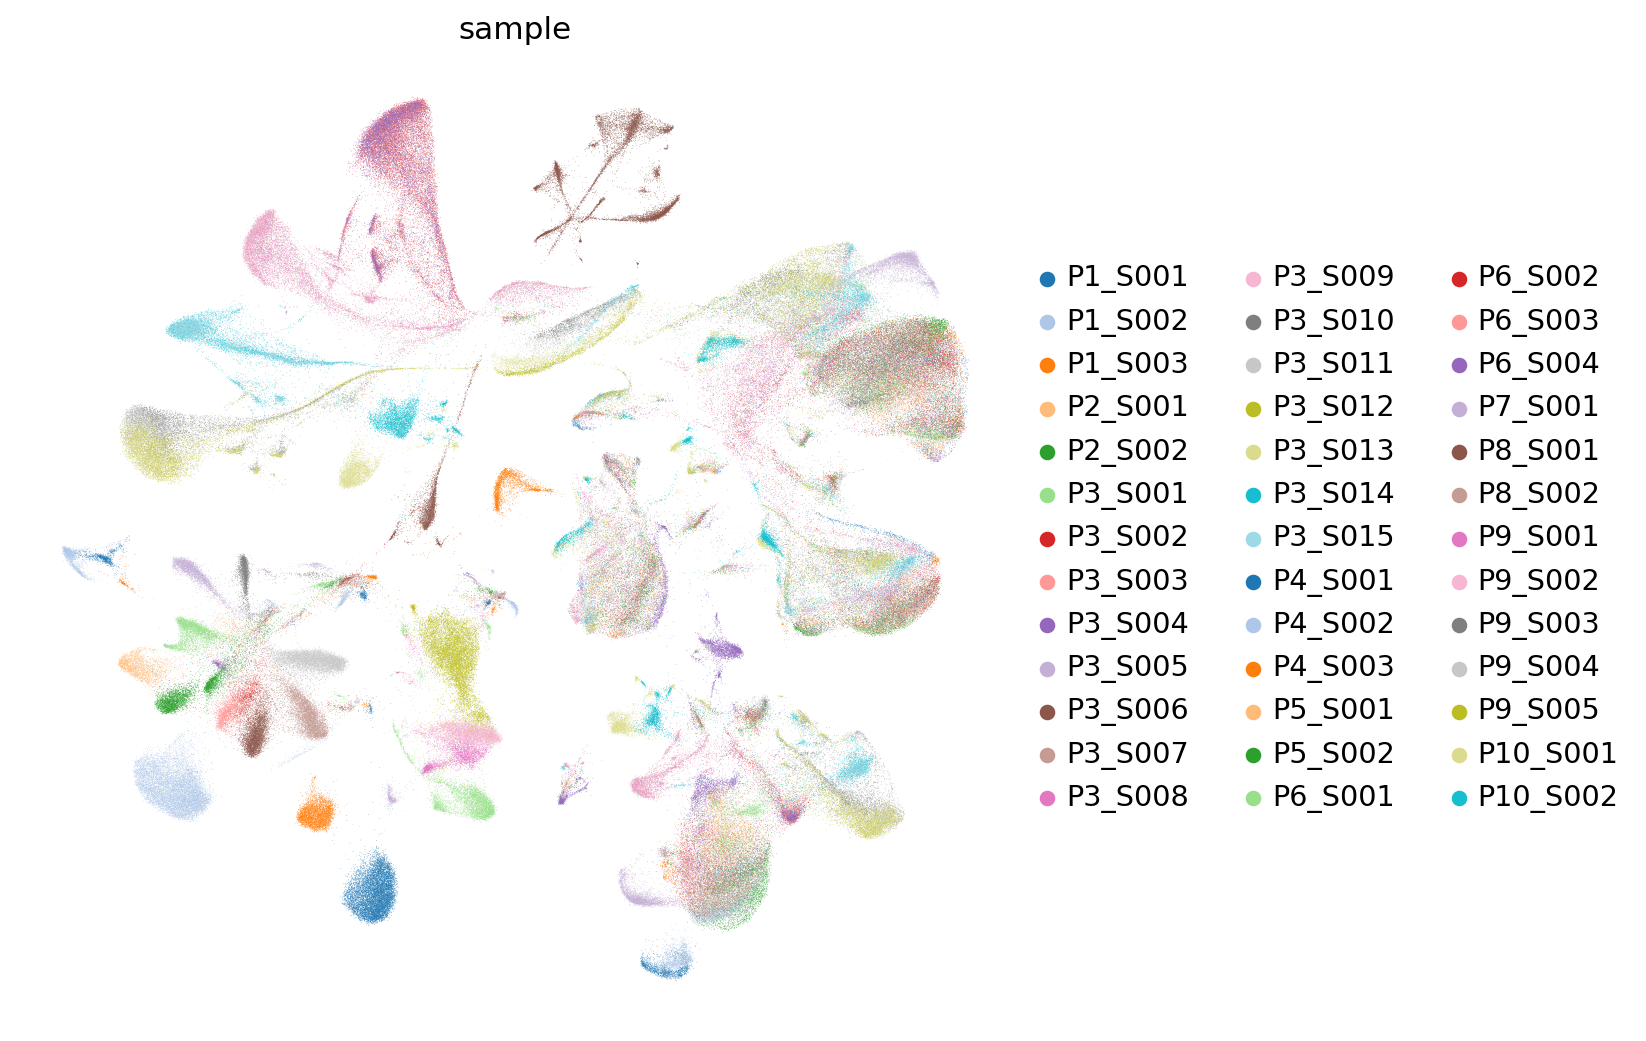

In [12]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_20,
    basis='pcaumap',
    color=["sample"],
    frameon=False,
)

In [13]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key='study',
    categorical_covariate_keys=["sample", "donor"],
    continuous_covariate_keys=["pct_mito_CBN", "nCount_CBN", "nFeature_CBN"]
)


In [14]:
## Creating and training a model
model = scvi.model.SCVI(adata, n_layers=2, n_latent=50)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [16]:
model.train(max_epochs=400)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██| 400/400 [3:25:09<00:00, 30.77s/it, loss=917, v_num=1]


In [17]:
## Obtaining model outputs
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

In [18]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
adata.obsm['X_scVIumap']=adata.obsm['X_umap']

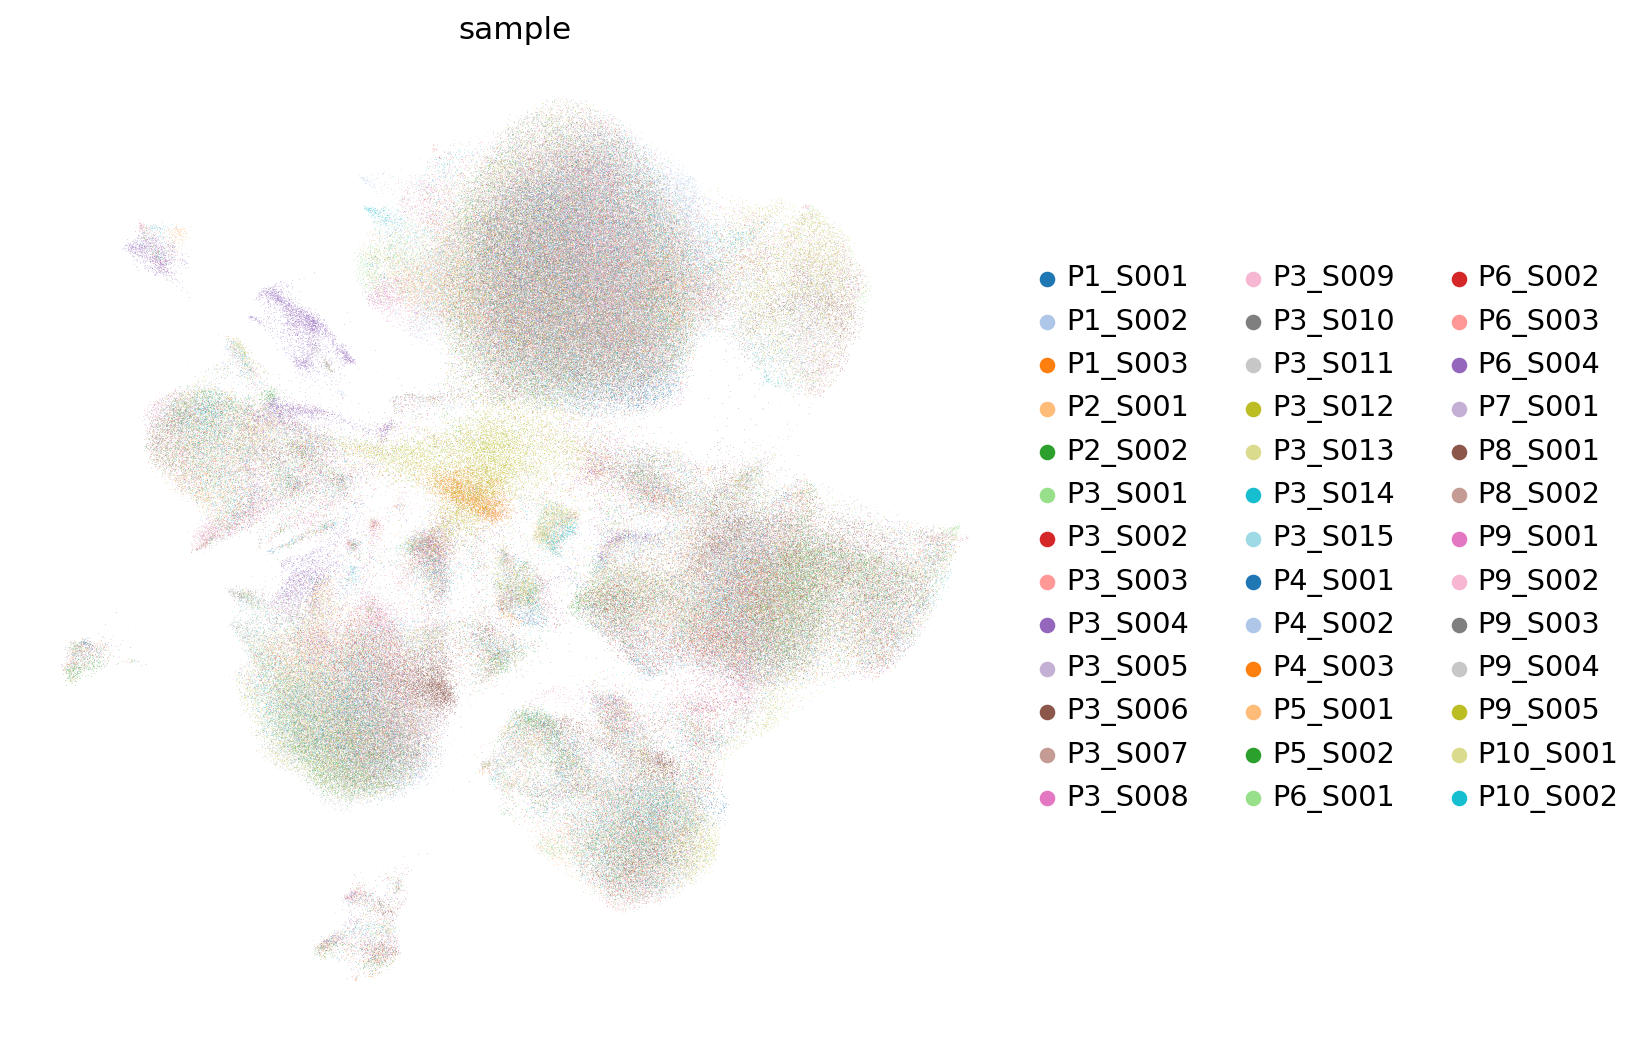

In [19]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_20,
    basis='scVIumap',
    color=["sample"],
    frameon=False,
)

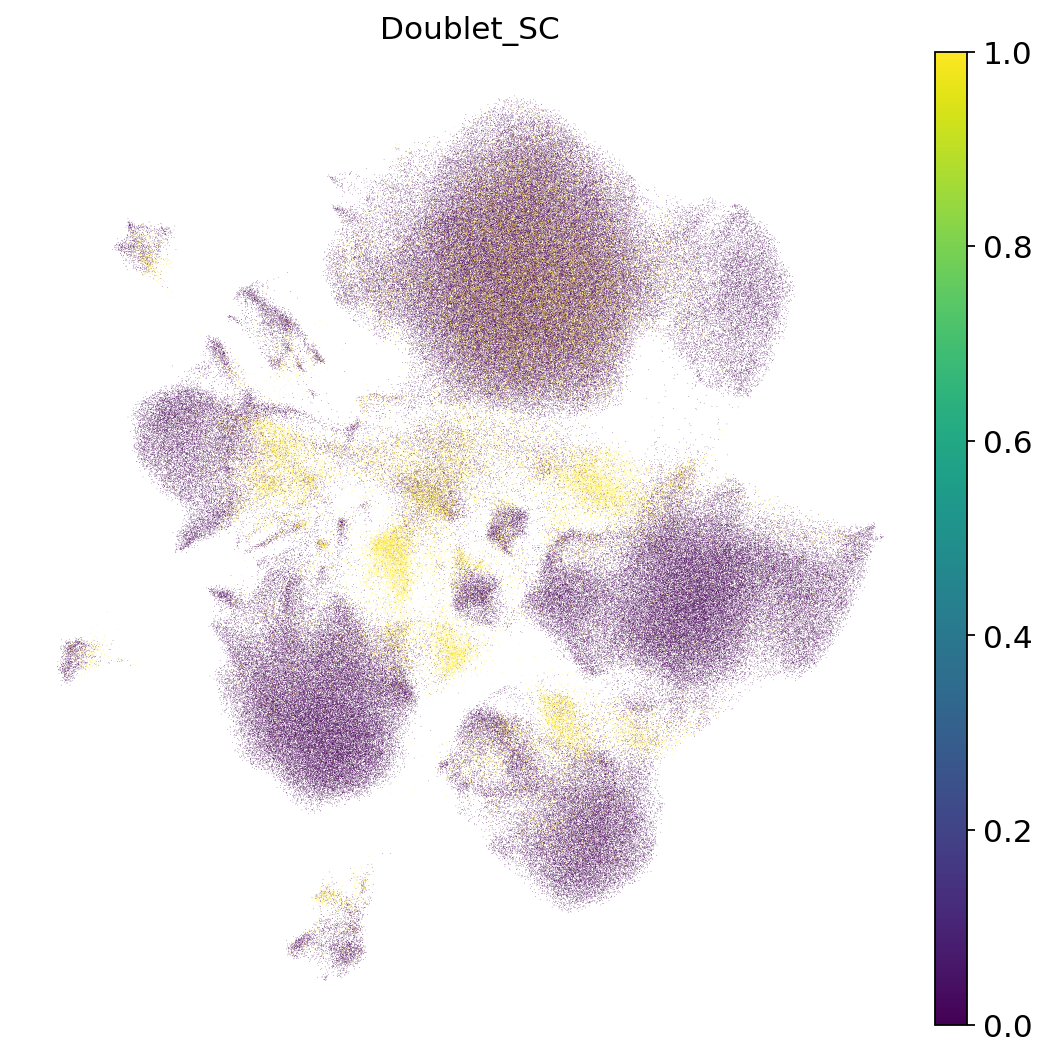

In [20]:
sc.pl.embedding(
    adata, 
    palette=sc.pl.palettes.vega_10,
    basis='scVIumap',
    color=["Doublet_SC"],
    frameon=False,
)

In [ ]:
model.save("/lorien/hlhs/rdata/human_v2/integrated/PART07.scvi_integration_model")

In [ ]:
adata.write_csvs(dirname='/lorien/hlhs/rdata/human_v2/integrated/PART07.scvi_integration.csvs', sep=",")

In [33]:
## The End